**Dataset: https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data/data**

## Problem Definition (Menentukan Masalah)

## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf

## Data Collection (Pengumpulan Data)

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/kia-digital/kia-digital-machine-learning/refs/heads/main/Maternal_Health_Risk%20_Dataset.csv')
data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


## Exploratory Data Analysis (EDA)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [5]:
print(f"There are {data.duplicated().sum()} duplicates data")
data.loc[data.duplicated(keep=False)].sort_values(by=data.columns.to_list())

There are 562 duplicates data


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
670,10,100,50,6.0,99.0,70,mid risk
849,10,100,50,6.0,99.0,70,mid risk
552,12,90,60,7.5,102.0,60,low risk
940,12,90,60,7.5,102.0,60,low risk
543,12,90,60,7.5,102.0,66,low risk
...,...,...,...,...,...,...,...
553,60,120,85,15.0,98.0,60,mid risk
772,60,120,85,15.0,98.0,60,mid risk
818,60,120,85,15.0,98.0,60,mid risk
114,63,140,90,15.0,98.0,90,high risk


Wow, 562 duplicates data. That's very big number. **What should we do now?**
Duplicate data takes up unnecessary storage space and slows down calculations at a minimum. At worst, duplicate data can skew analysis results and threaten the integrity of the data set. Including them will essentially lead to the model overfitting this subset of points. But in this case, we will try to analyze this data first to understand the distribution of the data.

### Univariate Analysis


C:\Users\hp\AppData\Local\Temp\ipykernel_2968\2935681441.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count = sns.countplot(x="RiskLevel", data=data, ax=ax[1], order=risk_order, palette=p_colors)


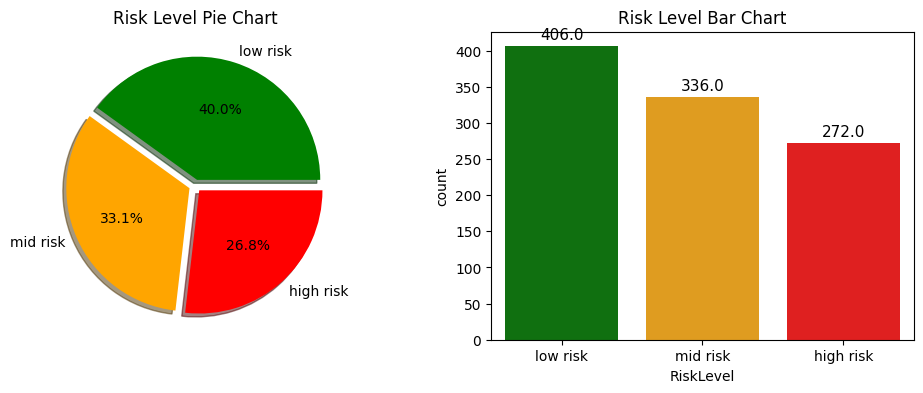

In [6]:
p_colors = ['green', 'orange', 'red']
risk_order = ["low risk", "mid risk", "high risk"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data["RiskLevel"].value_counts().plot(kind="pie", labels=risk_order, colors=p_colors, explode=[0.05, 0.05,  0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title("Risk Level Pie Chart")
ax[0].set_ylabel('')

count = sns.countplot(x="RiskLevel", data=data, ax=ax[1], order=risk_order, palette=p_colors)
for bar in count.patches:
    count.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
ax[1].set_title("Risk Level Bar Chart")
plt.show()

In [7]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Looks like Age, BS, and HeartRate variable has outlier in it. But this is just preliminary guess. Let's explore the data deeper.

In [8]:
def num_plot(data, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[0].set_title(f"{col} Distribution Histogram")
    ax[1].set_title(f"{col} Distribution Boxplot")

    plt.show()

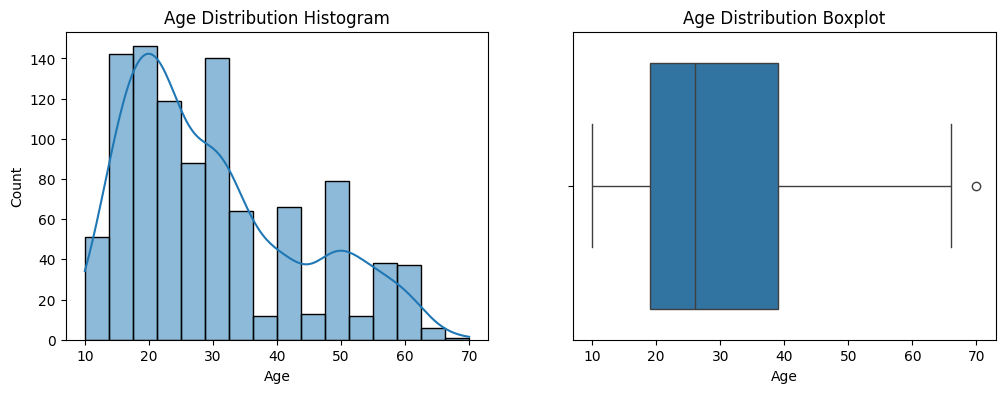

In [9]:
num_plot(data, "Age")

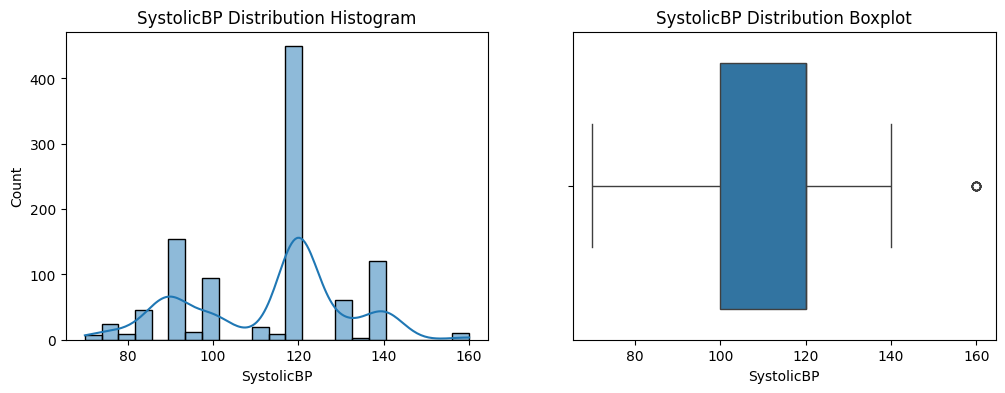

In [10]:
num_plot(data, "SystolicBP")

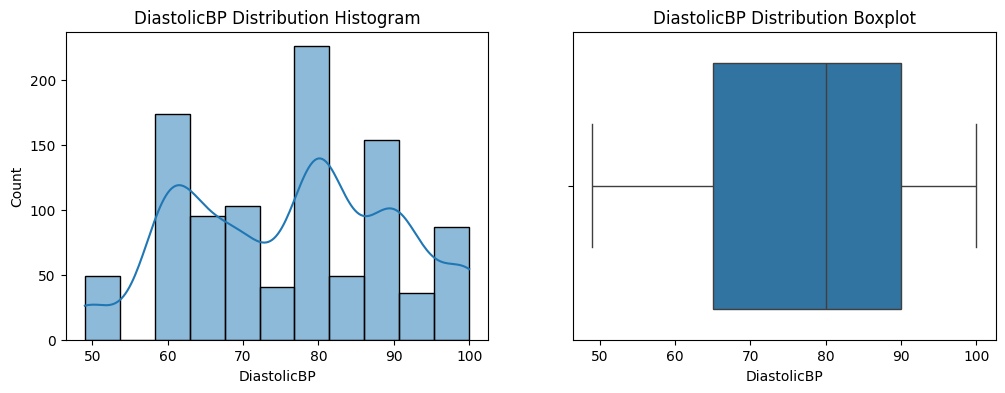

In [11]:
num_plot(data, "DiastolicBP")

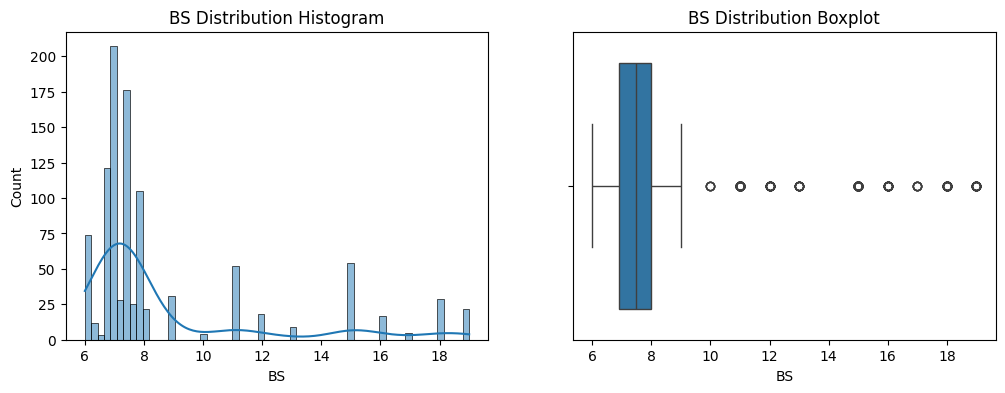

In [12]:
num_plot(data, "BS")

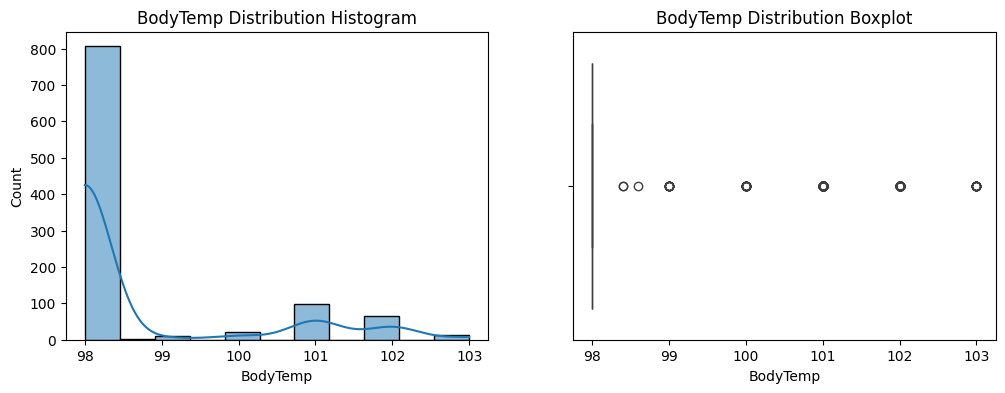

In [13]:
num_plot(data, "BodyTemp")

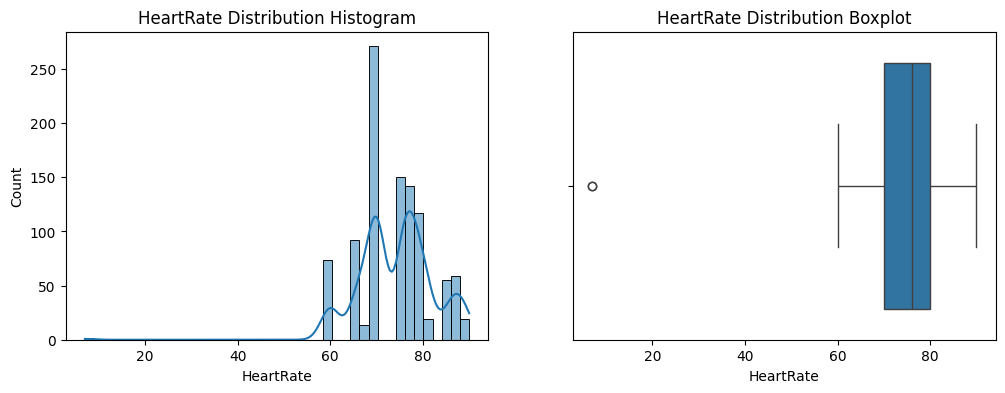

In [14]:
num_plot(data, "HeartRate")

**Observation**: Apparently, almost all variables has outlier that cause skewed distribution. For now, we will just ignore that outlier because that value seems to be a natural thing in this case, except for HeartRate. That variable has an outlier with a value that is too far from the other values.

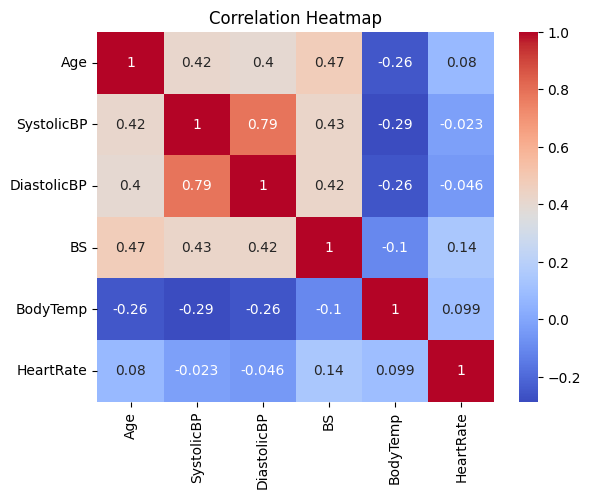

In [15]:
numeric_data = data.select_dtypes(include=['number'])

sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

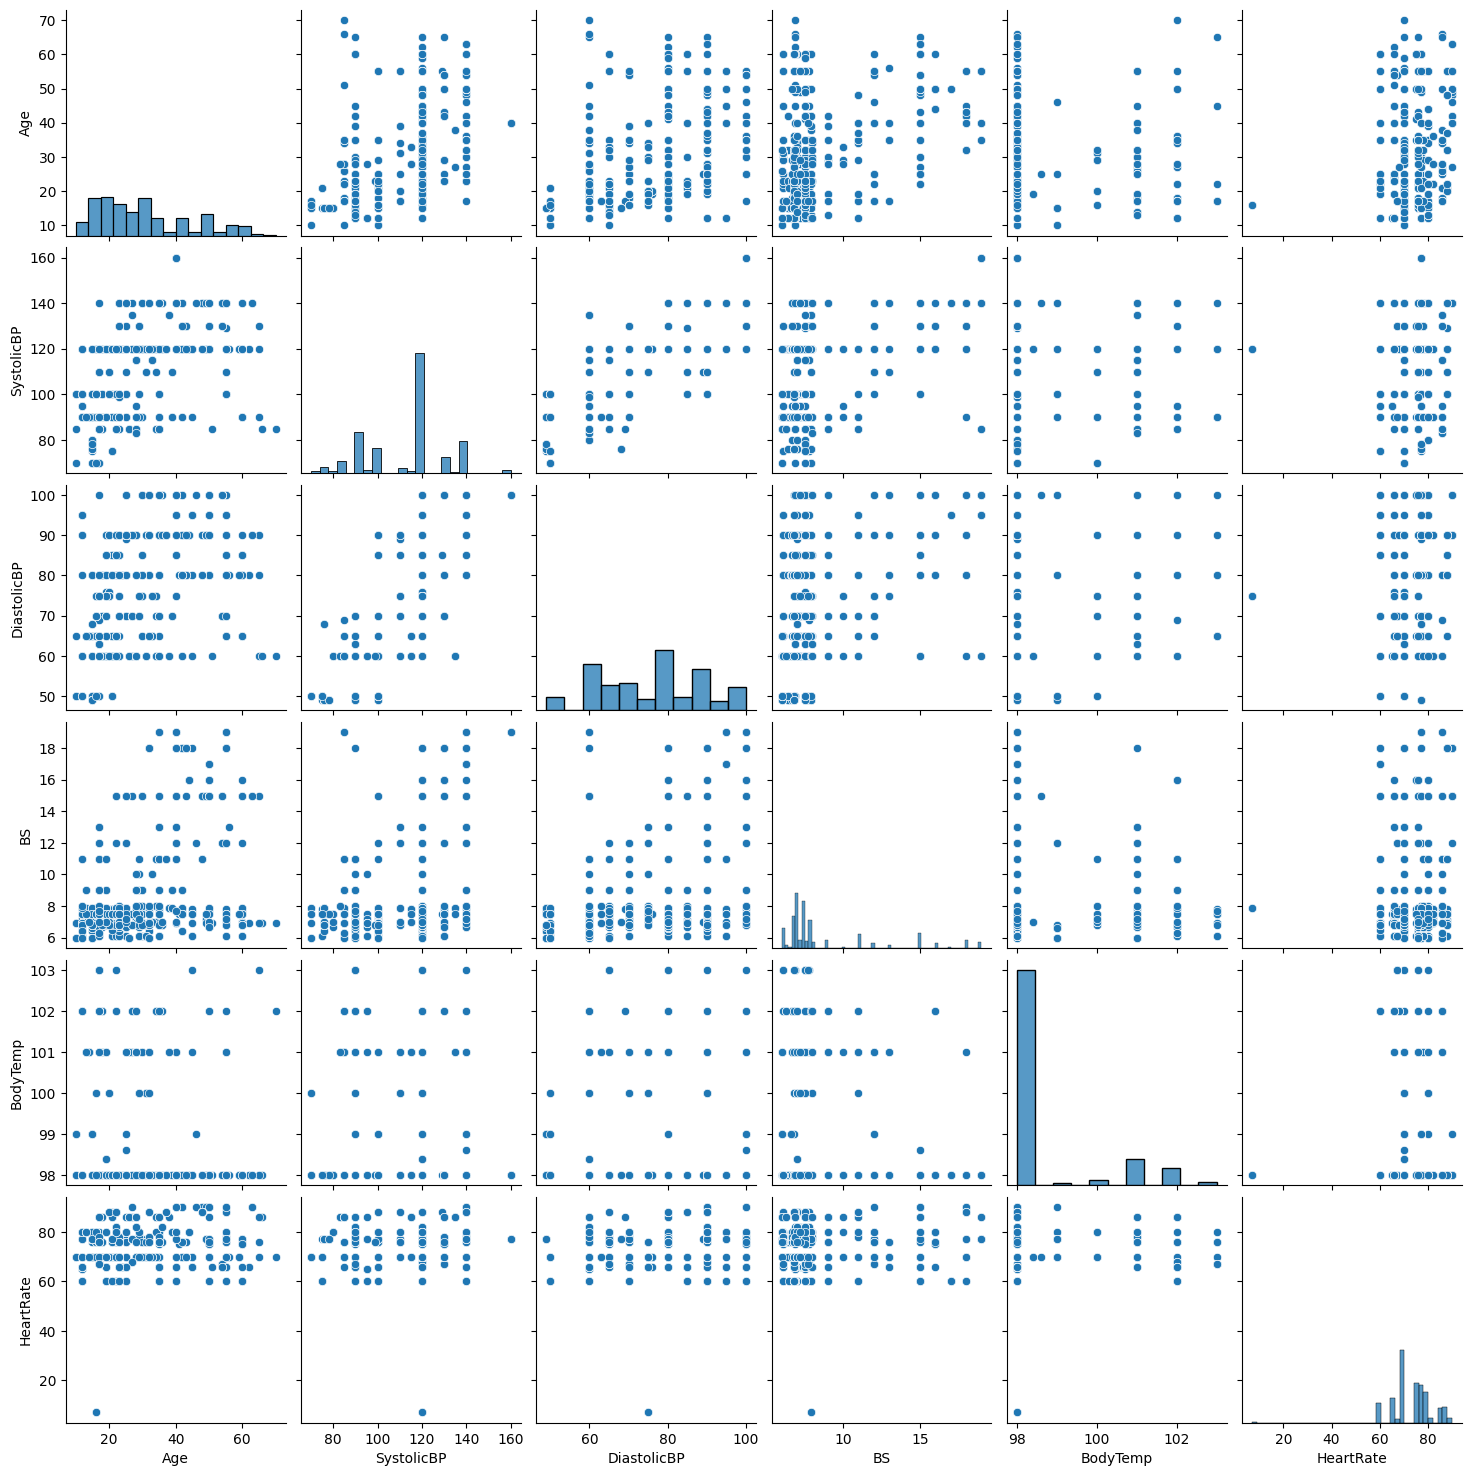

In [16]:
sns.pairplot(data)
plt.show()

**Observation**: SystolicBP and DiastolicBP are highly correlated. As we can see from the graph, they have positive correlation with correlation coefficient value = 0.79. This means that SystolicBP and DiastolicBP variable contains highly similar information and there is very little or no variance in information. This is known as a problem called MultiColinearity, which undermines the statistical significance of an independent variable. We can remove one of them because we don't want a redundant variable while making or training our model. But we will try to dig deeper to decide whether we need to remove these variable, and which variable we should remove

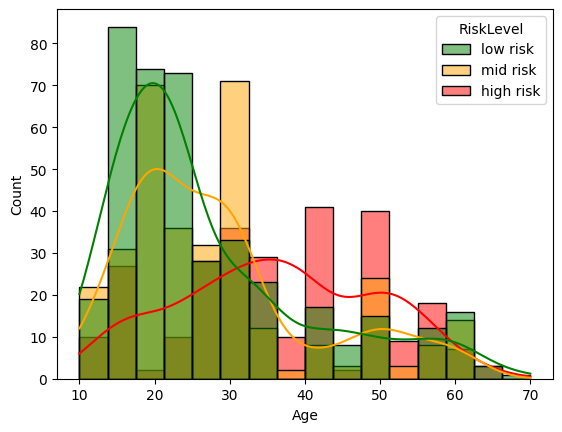

In [17]:
sns.histplot(data=data, x="Age", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [18]:
pd.crosstab(data.RiskLevel, data.Age).style.background_gradient(cmap='summer_r')

Age,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,54,55,56,59,60,62,63,65,66,70
RiskLevel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
high risk,0,7,3,3,0,0,24,0,2,0,0,5,5,0,21,0,2,5,8,10,0,18,2,3,22,2,6,2,2,34,0,4,3,0,1,1,16,2,22,0,9,17,1,0,7,0,2,1,0,0
low risk,2,15,2,0,56,10,18,8,28,11,27,28,42,3,16,0,5,7,2,6,7,18,0,2,21,0,0,0,0,1,1,15,0,0,8,0,4,5,5,1,0,12,0,2,13,1,0,2,1,1
mid risk,2,13,7,0,4,6,21,11,37,11,11,12,24,0,11,3,2,16,30,14,15,12,3,0,7,2,0,0,2,2,0,4,2,3,0,0,6,2,16,0,3,8,0,0,14,0,0,0,0,0


**Observation:**

1. Pregnant women aged below 24 years mostly has low health risk.
2. Health risks will start to increase after that age (starting from the age of 25 years).
3. Surprisingly, the health risk of pregnant women over 59 years old is decreased

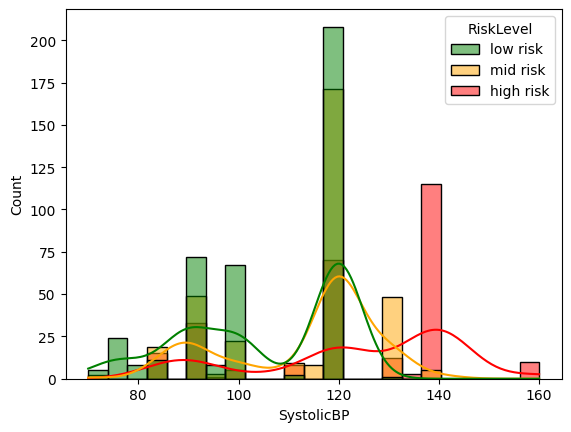

In [19]:
sns.histplot(data=data, x="SystolicBP", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [20]:
pd.crosstab(data.RiskLevel, data.SystolicBP).style.background_gradient(cmap='summer_r')

SystolicBP,70,75,76,78,80,83,85,90,95,99,100,110,115,120,129,130,135,140,160
RiskLevel,,,,,,,,,,,,,,,,,,,
high risk,0,0,0,0,0,2,13,33,1,0,5,8,0,70,0,12,3,115,10
low risk,5,8,16,3,5,0,11,72,8,2,65,2,0,208,1,0,0,0,0
mid risk,2,0,0,0,0,0,19,49,3,0,22,9,8,171,0,48,0,5,0


**Observation:**

1. Pregnant women with upper value of blood pressure >= 100 mmHg mostly has low health risk.
2. The higher pregnant women's blood pressure, the higher the health risk

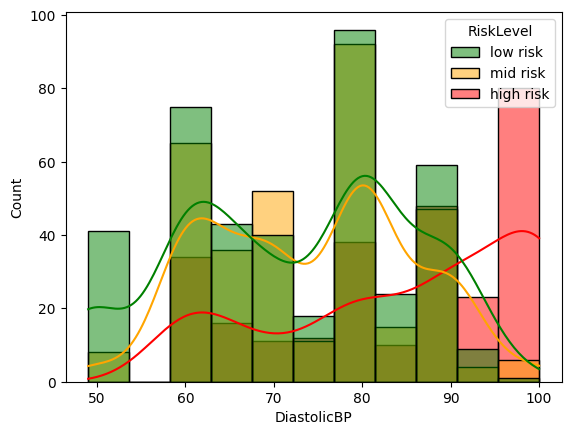

In [21]:
sns.histplot(data=data, x="DiastolicBP", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [22]:
pd.crosstab(data.RiskLevel, data.DiastolicBP).style.background_gradient(cmap='summer_r')

DiastolicBP,49,50,60,63,65,68,69,70,75,76,80,85,89,90,95,100
RiskLevel,,,,,,,,,,,,,,,,
high risk,0,0,34,2,14,0,1,10,12,0,38,10,0,48,23,80
low risk,25,16,75,2,41,2,0,38,15,3,96,24,1,58,9,1
mid risk,0,8,65,4,32,0,0,52,11,0,92,15,0,47,4,6


**Observation:**

1. This variable has pretty similar pattern as SystolicBP. This is not surprising since they're highly correlated.

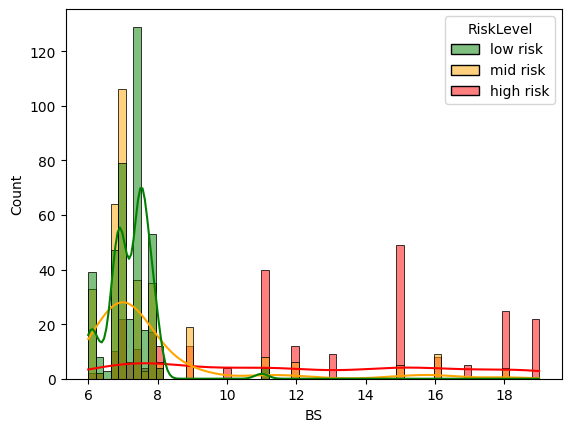

In [23]:
sns.histplot(data=data, x="BS", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [24]:
pd.crosstab(data.RiskLevel, data.BS).style.background_gradient(cmap='summer_r')

BS,6.000000,6.100000,6.300000,6.400000,6.500000,6.600000,6.700000,6.800000,6.900000,7.000000,7.010000,7.100000,7.200000,7.500000,7.600000,7.700000,7.800000,7.900000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,15.000000,16.000000,17.000000,18.000000,19.000000
RiskLevel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
high risk,0,2,2,0,0,0,0,10,8,9,5,0,6,11,0,4,5,12,12,12,4,40,12,9,49,8,5,25,22
low risk,7,32,0,8,1,2,10,37,47,29,3,8,14,129,1,17,19,34,4,0,0,4,0,0,0,0,0,0,0
mid risk,14,19,0,2,0,0,23,41,58,41,7,0,0,36,0,3,21,14,6,19,0,8,6,0,5,9,0,4,0


**Observation:**

1. Almost every pregnant women with blood glucose level >= 8 has high health risk.
2. But otherwise, they seems to have lower health risk with blood glucose < 8

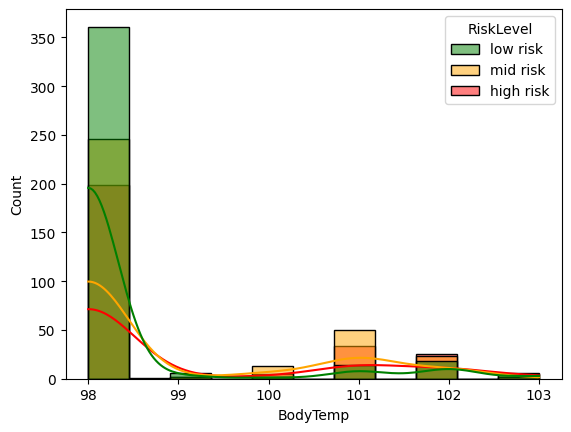

In [25]:
sns.histplot(data=data, x="BodyTemp", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [26]:
pd.crosstab(data.RiskLevel, data.BodyTemp).style.background_gradient(cmap='summer_r')

BodyTemp,98.000000,98.400000,98.600000,99.000000,100.000000,101.000000,102.000000,103.000000
RiskLevel,,,,,,,,
high risk,199,0,1,2,5,34,25,6
low risk,359,2,0,6,2,14,18,5
mid risk,246,0,0,2,13,50,23,2


**Observation:**

1. Most pregnant women seem to have a body temperature of 98 F, which is normal body temperature
2. Pregnant women with body temperature >= 100 mostly has higher health risk

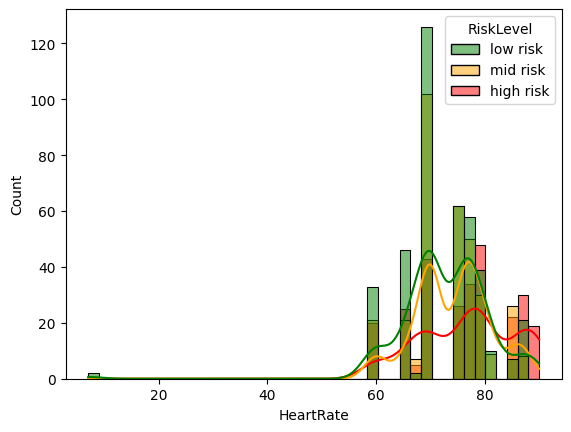

In [27]:
sns.histplot(data=data, x="HeartRate", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [28]:
pd.crosstab(data.RiskLevel, data.HeartRate).style.background_gradient(cmap='summer_r')

HeartRate,7,60,65,66,67,68,70,75,76,77,78,80,82,86,88,90
RiskLevel,,,,,,,,,,,,,,,,
high risk,0,20,0,25,5,0,43,6,20,25,9,48,0,22,30,19
low risk,2,33,2,44,2,0,126,7,55,56,2,39,10,7,21,0
mid risk,0,21,3,18,5,2,102,6,56,15,35,30,9,26,8,0


**Observation:**

1. As we mentioned before, HeartRate variable has outlier that with a value that looks unnatural, which is 6 bpm.
2. Health risks seem to be getting higher along with the number of heart rate.

### Multivariate Analysis

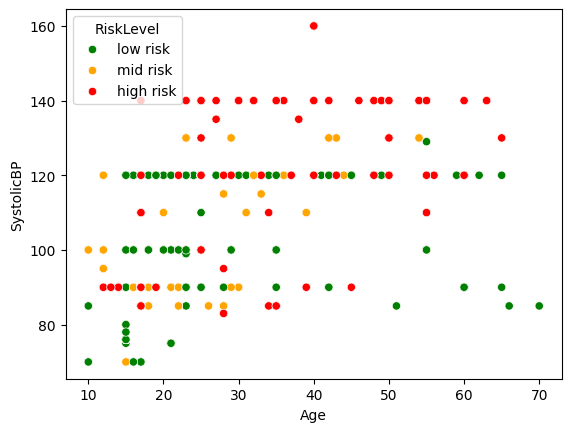

In [29]:
sns.scatterplot(data=data, x="Age", y="SystolicBP", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with high SystolicBP seems to have a high health risk, regardless of their age.
2. Having low SystolicBP at a young age (under 50 years) doesn't guarantee does not guarantee our health risk is low, but it seems to have it in old age makes our health risks lower.

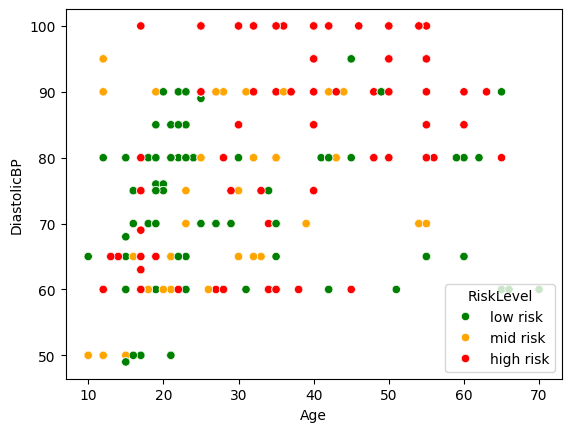

In [30]:
sns.scatterplot(data=data, x="Age", y="DiastolicBP", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. We can see the same pattern as before, since SystolicBP and DiastolicBP are highly correlated

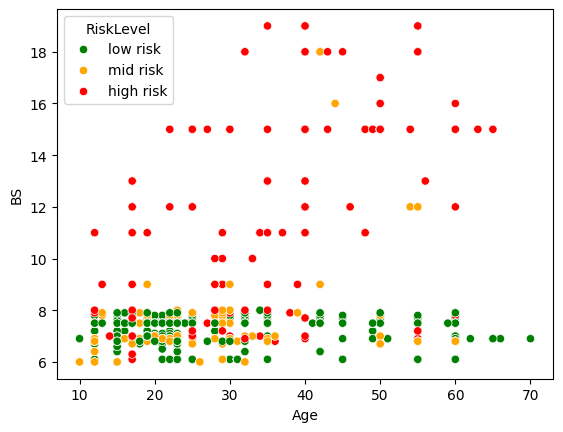

In [31]:
sns.scatterplot(data=data, x="Age", y="BS", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with high blood glucose level seems to have a high health risk, regardless of their age.

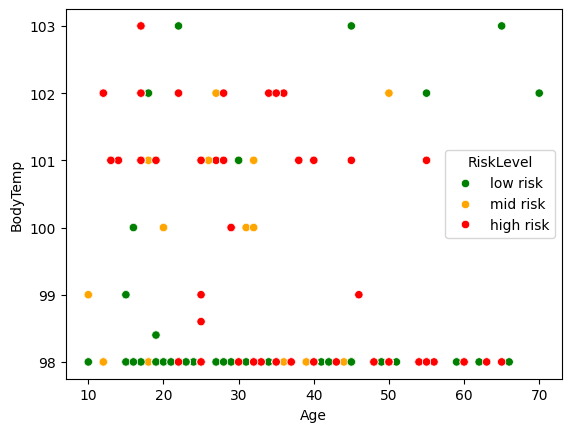

In [32]:
sns.scatterplot(data=data, x="Age", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Younger women with normal body temperature mostly have low health risk, but they'll have higher risk if they have high body temperature.
2. High body temperature for older women doesn't appear to significantly affect their health risks

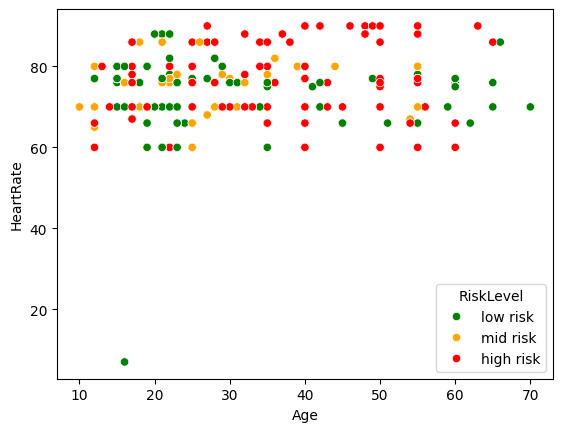

In [33]:
sns.scatterplot(data=data, x="Age", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. It seems that heart rate has less effect on pregnant women's health risk compared to age

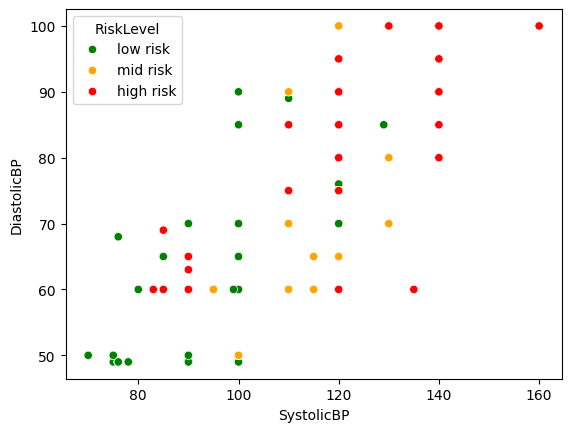

In [34]:
sns.scatterplot(data=data, x="SystolicBP", y="DiastolicBP", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Apparently, pregnant women with lower SystolicBP and DiastolicBP seems to have a lower health risk.
2. But otherwise, the higher SystolicBP and DiastolicBP they have, the higher their health risk.

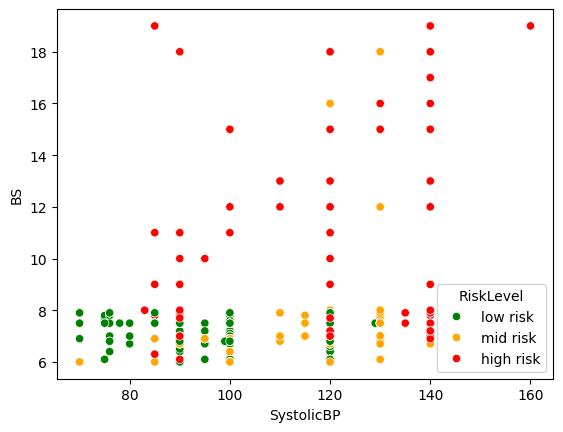

In [35]:
sns.scatterplot(data=data, x="SystolicBP", y="BS", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. We can see almost similar pattern as before.
2. However, a higher BS value seems to affect the health risks of pregnant women more.

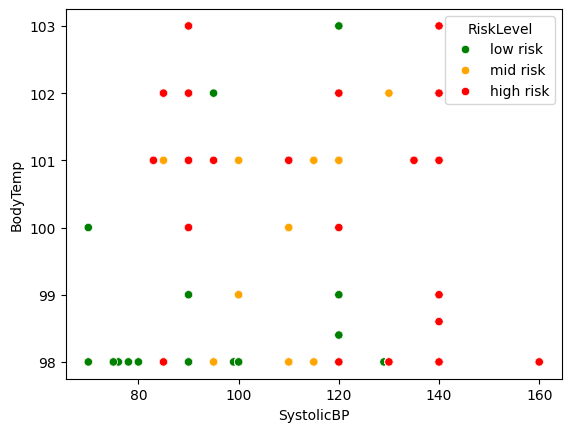

In [36]:
sns.scatterplot(data=data, x="SystolicBP", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with normal body temperature and low SystolicBP mostly has low health risk.
2. But the one who has high SystolicBP seems to have higher health risk, regardless of their body temperature.

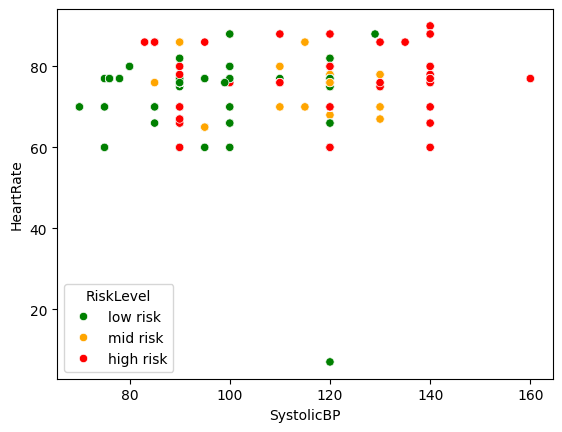

In [37]:
sns.scatterplot(data=data, x="SystolicBP", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. HeartRate value seems has less effect on pregnant women's health risk compared to SystolicBP.
2. Looks like HeartRate variabel isn't really useful.

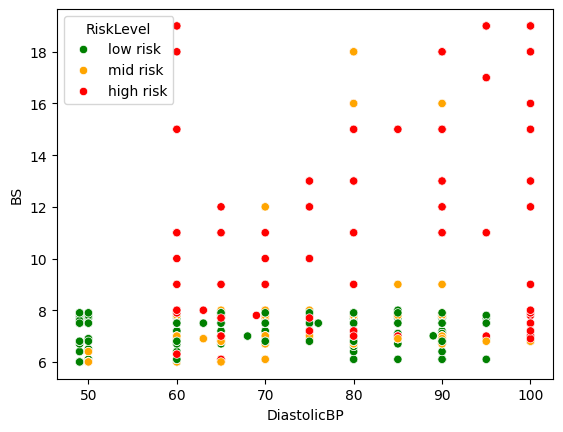

In [38]:
sns.scatterplot(data=data, x="DiastolicBP", y="BS", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with high blood glucose level has higher health risk, regardless of their DiastolicBP.

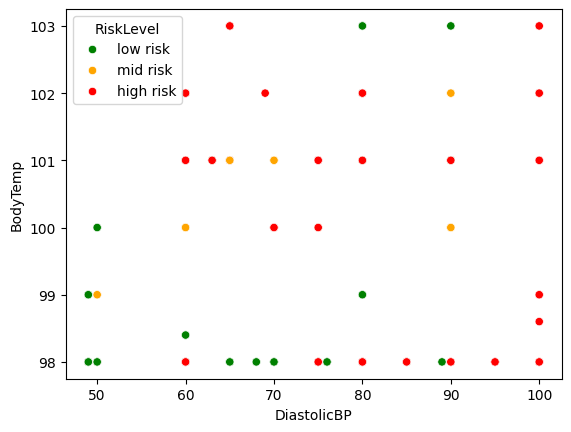

In [39]:
sns.scatterplot(data=data, x="DiastolicBP", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with low DiastolicBP and low body temperature mostly has low health risk, but their health risk will get higher if they have higher body temperature.

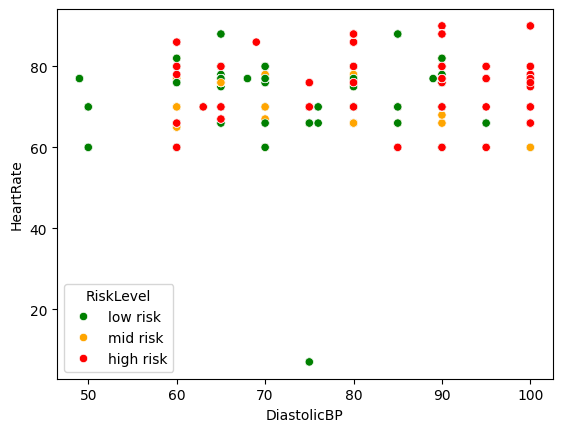

In [40]:
sns.scatterplot(data=data, x="DiastolicBP", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Again, HeartRate value seems has less effect on pregnant women's health risk compared to DiastolicBP.
2. Looks like HeartRate variabel isn't really useful.

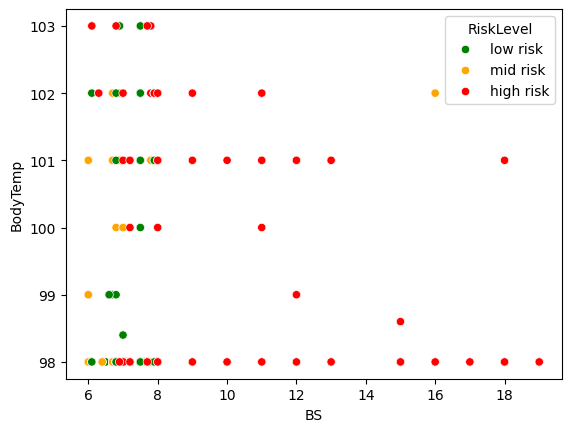

In [41]:
sns.scatterplot(data=data, x="BS", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with high blood glucose level seems to have a high health risk, regardless of their body temperature.

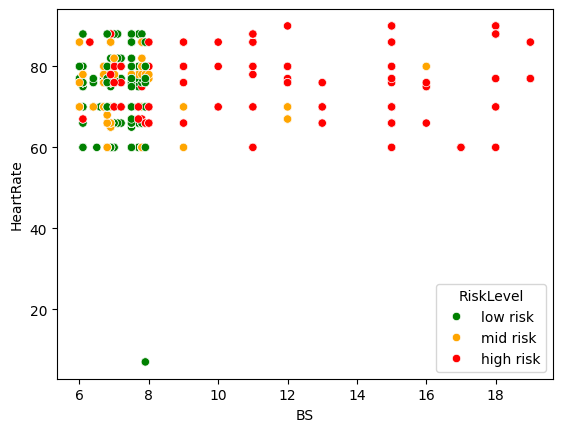

In [42]:
sns.scatterplot(data=data, x="BS", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Apparently, Pregnant women with higher blood glucose level seems to have a higher health risk, regardless of their heart rate.

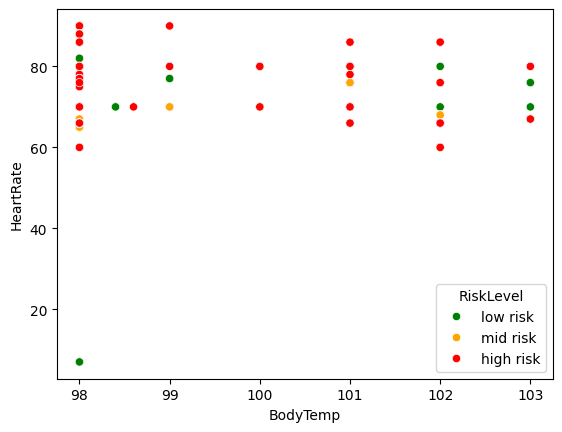

In [43]:
sns.scatterplot(data=data, x="BodyTemp", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**

1. Pregnant women with higher body temperature seems to have a higher health risk, regardless of their heart rate (please note that according to previous analysis, pregnant women in this obervation mostly has 98 F body temperature).
2. HeartRate variable really isn't helpful in this case.

## Data Preprocessing (Pra-pemrosesan Data)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [45]:
data = data.rename(columns={'BS': 'BloodSugar'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BloodSugar   1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Ubah satuan fahrenheit dalam BodyTemp menjadi Celcius

In [46]:
# Convert Fahrenheit to Celsius for the 'BodyTemp' column
data['BodyTemp'] = (data['BodyTemp'] - 32) * 5/9

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BloodSugar   1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [47]:
data.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,37.036160,74.301775
std,13.474386,18.403913,13.885796,3.293532,0.761880,8.088702
min,10.000000,70.000000,49.000000,6.000000,36.666667,7.000000
25%,19.000000,100.000000,65.000000,6.900000,36.666667,70.000000
50%,26.000000,120.000000,80.000000,7.500000,36.666667,76.000000
75%,39.000000,120.000000,90.000000,8.000000,36.666667,80.000000
max,70.000000,160.000000,100.000000,19.000000,39.444444,90.000000


#### Outlier Handling

As we know from the previous analysis, in this dataset there are several variables that have outliers, but even so most of those values still make sense in real life. The only variable that has an outlier with an unreasonable value is HeartRate. In this variable, there are two observations that have a heart rate value of 7 bpm (beats per minute). A normal resting heart rate for adults ranges from 60 to 100 beats per minute, and the lowest recorded resting heart rate in human history was 25 bpm. Therefore, we will drop this 2 records that has a heart rate value of 7 because that value doesn't make any sense, and most likely is an input error.

We won't store processed data in the original variable, but instead we will store it in the new variable, so we can compare it with the original data.

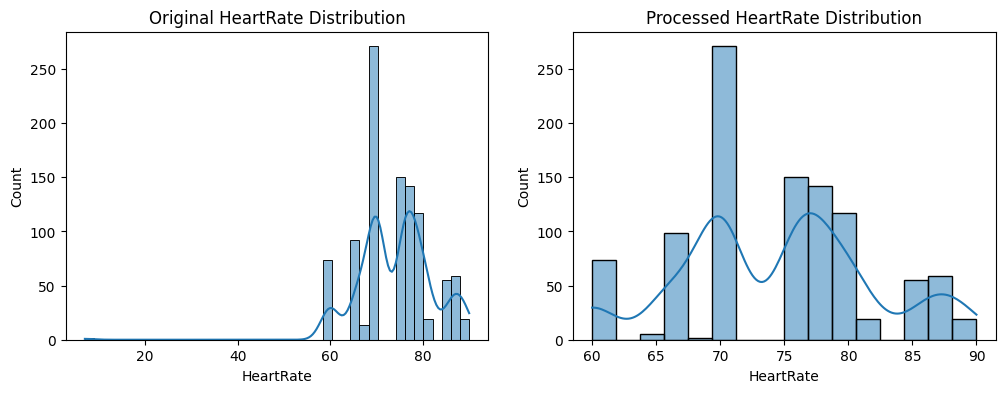

In [48]:
data_proc = data.drop(data.index[data.HeartRate == 7])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=data, x="HeartRate", kde=True, ax=ax[0])
sns.histplot(data=data_proc, x="HeartRate", kde=True, ax=ax[1])
ax[0].set_title("Original HeartRate Distribution")
ax[1].set_title("Processed HeartRate Distribution")
plt.show()

#### Hapus Irrelevant Features

In [49]:
data_proc = data_proc.drop(["HeartRate"], axis=1)

**Why we drop records that has outlier on HeartRate variable if we will delete that variable in the end?** The answer is because it has input error in it, so that records maybe not legit. It could be that the label given is also not correct, so it will mislead the training process which makes the model becomes less accurate.

## Modelling

### Tensorflow

In [50]:
# Persiapan dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
data_proc = data_proc.dropna()
X = data_proc.drop("RiskLevel", axis=1)
y = data_proc["RiskLevel"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Min Max Scaler
# min_max = MinMaxScaler()
# X_scaled = min_max.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [51]:
from imblearn.over_sampling import SMOTE

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Fit dan resample data
X_train, y_train = smote.fit_resample(X_train, y_train)

c:\Users\hp\miniconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [52]:
df = data_proc.copy()
# df['RiskLevel'] = le.fit_transform(df['RiskLevel'])
df

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,RiskLevel
0,25,130,80,15.0,36.666667,high risk
1,35,140,90,13.0,36.666667,high risk
2,29,90,70,8.0,37.777778,high risk
3,30,140,85,7.0,36.666667,high risk
4,35,120,60,6.1,36.666667,low risk
...,...,...,...,...,...,...
1009,22,120,60,15.0,36.666667,high risk
1010,55,120,90,18.0,36.666667,high risk
1011,35,85,60,19.0,36.666667,high risk
1012,43,120,90,18.0,36.666667,high risk


## Deep Learning

In [53]:
# Membangun model TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1536      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [55]:
# Melatih model
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=32, callbacks=[checkpoint, reduce_lr])

Epoch 1/500
24/25 [===========================>..] - ETA: 0s - loss: 0.8839 - accuracy: 0.5911
Epoch 1: val_loss improved from inf to 1.03540, saving model to best_model.keras
25/25 [==============================] - 3s 27ms/step - loss: 0.8847 - accuracy: 0.5909 - val_loss: 1.0354 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 2/500
23/25 [==========================>...] - ETA: 0s - loss: 0.7476 - accuracy: 0.6617
Epoch 2: val_loss improved from 1.03540 to 1.00118, saving model to best_model.keras
25/25 [==============================] - 0s 15ms/step - loss: 0.7544 - accuracy: 0.6584 - val_loss: 1.0012 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 3/500
23/25 [==========================>...] - ETA: 0s - loss: 0.6990 - accuracy: 0.6481
Epoch 3: val_loss improved from 1.00118 to 0.97618, saving model to best_model.keras
25/25 [==============================] - 0s 14ms/step - loss: 0.7038 - accuracy: 0.6442 - val_loss: 0.9762 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 4/500
24/25 [================

In [56]:
# Evaluasi
# model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi pada data test: {accuracy:.2f}")

7/7 [==============================] - 0s 5ms/step - loss: 0.6424 - accuracy: 0.7044
Akurasi pada data test: 0.70


In [57]:
# Prediksi dan laporan klasifikasi
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

   high risk       0.71      0.96      0.81        48
    low risk       0.67      0.84      0.75        83
    mid risk       0.79      0.38      0.51        72

    accuracy                           0.70       203
   macro avg       0.72      0.73      0.69       203
weighted avg       0.72      0.70      0.68       203



Accuracy masih 0.7

### Fine Tuning

In [58]:
import keras_tuner as kt
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', 0.1, 0.5, step=0.1)))

    # Hidden layers
    for i in range(hp.Int('num_hidden_layers', 2, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [59]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,                # Uji 10 kombinasi
    executions_per_trial=1,
    directory='kerastuner_dir',
    project_name='maternal_health'
)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2)


Reloading Tuner from kerastuner_dir\maternal_health\tuner0.json


In [60]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best input units: {best_hps.get('units_input')}")
print(f"Best number of hidden layers: {best_hps.get('num_hidden_layers')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best input units: 128
Best number of hidden layers: 3
Best learning rate: 0.01


## Decision Tree

In [61]:
df = data_proc.copy()
df['RiskLevel'] = le.fit_transform(df['RiskLevel'])
df_temp = df.loc[:, df.columns != 'RiskLevel']

# SMOTE
# df_X, df_y = smote.fit_resample(df_temp, df['RiskLevel'])
# df = df_X.join(df_y)

# Data Split
train_ds, test_ds = train_test_split(df, test_size=0.2, random_state=42)

# Drop Null
train_ds = train_ds.dropna()
test_ds = test_ds.dropna()

# Cast Integer
train_ds['RiskLevel'] = train_ds['RiskLevel'].astype(int)
test_ds['RiskLevel'] = test_ds['RiskLevel'].astype(int)


In [62]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=500, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

Random Forest Accuracy: 0.8177339901477833
Gradient Boosting Accuracy: 0.7980295566502463


In [63]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_gb = gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

Gradient Boosting Accuracy: 0.80
              precision    recall  f1-score   support

   high risk       0.80      0.94      0.87        48
    low risk       0.88      0.70      0.78        83
    mid risk       0.73      0.82      0.77        72

    accuracy                           0.80       203
   macro avg       0.80      0.82      0.81       203
weighted avg       0.81      0.80      0.80       203



In [64]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_rf)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Gradient Boosting Accuracy: 0.80
              precision    recall  f1-score   support

   high risk       0.80      0.94      0.87        48
    low risk       0.88      0.70      0.78        83
    mid risk       0.73      0.82      0.77        72

    accuracy                           0.80       203
   macro avg       0.80      0.82      0.81       203
weighted avg       0.81      0.80      0.80       203



In [69]:
model.save('model_klasifikasi_maternal', save_format='tf')

INFO:tensorflow:Assets written to: model_klasifikasi_maternal\assets


## Deployment

In [70]:
!pip install pipreqs

  Using cached pipreqs-0.5.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached yarg-0.1.9-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached backcall-0.2.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Using cached jupyterlab_pygments-0.3.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached mistune-3.1.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached nbclient-0.10.2-py3-none-any.whl.metadata (8.3 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached pandocfilters-1.5.1-py2.py3-none-a

  DEPRECATION: Building 'docopt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'docopt'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [71]:
!pipreqs

INFO: Not scanning for jupyter notebooks.
